In [156]:
import pandas as pd
import numpy as np
from nltk.stem import WordNetLemmatizer, SnowballStemmer

Only take restaurants into account. We want to find out, what it is what makes restaurants go up or down in rating significantly.

In [2]:
size = 100000
business_chunks = pd.read_json('../data/yelp_academic_dataset_business.json', lines=True,
                    dtype={
                        "business_id": str,
                        "name": str,
                        "address": str,
                        "city": str,
                        "state": str,
                        "postal code": str,
                        "latitude": float,
                        "longitude": float,
                        "stars": float,
                        "review_count": int,
                        "is_open": int
                    }, chunksize=size)

chunk_list = []
for chunk in business_chunks:
    chunk = chunk[chunk['categories'].notnull()]
    
    # only keep restaurants
    chunk = chunk.loc[[('Restaurant' in x) for x in chunk['categories']]]
    
    # only certain columns
    # chunk = chunk[['business_id', 'name','stars', 'is_open','review_count']]
    
    chunk_list.append(chunk)

restaurants = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)


In [3]:
restaurants.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,1,"{'RestaurantsTableService': 'True', 'WiFi': 'u...","Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'..."
1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ..."
2,D4JtQNTI4X3KcbzacDJsMw,Bob Likes Thai Food,3755 Main St,Vancouver,BC,V5V,49.251342,-123.101333,3.5,169,1,"{'GoodForKids': 'True', 'Alcohol': 'u'none'', ...","Restaurants, Thai","{'Monday': '17:0-21:0', 'Tuesday': '17:0-21:0'..."
3,jFYIsSb7r1QeESVUnXPHBw,Boxwood Biscuit,740 S High St,Columbus,OH,43206,39.947007,-82.997471,4.5,11,1,None,"Breakfast & Brunch, Restaurants","{'Saturday': '8:0-14:0', 'Sunday': '8:0-14:0'}"
4,HPA_qyMEddpAEtFof02ixg,Mr G's Pizza & Subs,474 Lowell St,Peabody,MA,01960,42.541155,-70.973438,4.0,39,1,"{'RestaurantsGoodForGroups': 'True', 'HasTV': ...","Food, Pizza, Restaurants","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'..."


Get the restaurant with the most reviews as an example

In [123]:
most_reviewed_restaurant_ids = restaurants.sort_values('review_count', ascending=False).head(1000)['business_id'].values

In [12]:
most_reviewed_restaurant_id = restaurants.loc[restaurants.review_count == restaurants.review_count.max(), 'business_id'].values[0]
most_reviewed_restaurant_id

'4CxF8c3MB7VAdY8zFb2cZQ'

Now get the corresponding reviews

In [124]:
size = 1000000
review_chunks = pd.read_json('../data/yelp_academic_dataset_review.json', lines=True,
                    dtype={
                    "review_id": str,
                    "user_id": str,
                    "business_id": str,
                    "stars": int,
                    "date": str,
                    "text": str,
                    "useful": int,
                    "funny": int,
                    "cool": int,
                }, chunksize=size)

chunk_list = []
for chunk in review_chunks:
    # only keep tips of current or former elite users.
    chunk = chunk[chunk.business_id.isin(most_reviewed_restaurant_ids)]
    chunk_list.append(chunk)

reviews = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)

In [125]:
reviews.shape # should have roughly 9000 for single case, 35k for top 5 restaurants

(1147829, 9)

Check the reviews over time, how the mean varies per month

In [17]:
reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,yearmon
0,X4-EMXS7-XJZ9tuVJhn0-g,lzQLHoJdaMNwiNt76wrc4g,4CxF8c3MB7VAdY8zFb2cZQ,2,5,2,3,I am alway leery of places the trade on schtic...,2011-08-24 21:59:48,2011-08
1,19msT9vUbN1xI17FTsFBOw,s-xMG4eoG1YO0N795PaAiQ,4CxF8c3MB7VAdY8zFb2cZQ,4,0,0,0,"It's a must when visitors come to town, not th...",2015-10-07 21:39:23,2015-10
2,GAzyhQ6FquMy-W_IM55NcA,9tW7SD-mL6PlHIOvORVMig,4CxF8c3MB7VAdY8zFb2cZQ,4,0,0,0,The maple bacon bar is to die for. I live in P...,2012-07-16 02:07:27,2012-07
3,o047kXCHybKL6vUYFcUOHg,YP5RiJiv0nOpyo0tHYkdwA,4CxF8c3MB7VAdY8zFb2cZQ,3,1,0,0,Innovative types of donuts but a bit priceyy (...,2016-10-13 23:56:59,2016-10
4,5DYJBTm9V9w0xcrXVcqmRg,8ZoyTgGq0wUHDNISHU7D0Q,4CxF8c3MB7VAdY8zFb2cZQ,4,0,0,0,"Love! Bacon-Maple Bars are my favorite, but s...",2014-10-11 06:52:26,2014-10


In [126]:
reviews['yearmon'] = reviews['date'].str[0:7]
reviews['year'] = reviews['date'].str[0:4]
reviews['quarter'] = pd.to_datetime(reviews['date'], format='%Y-%m-%d').dt.quarter

<AxesSubplot:>

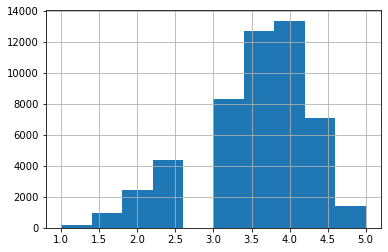

In [127]:
# plot overall star ratings
restaurants.stars.hist()

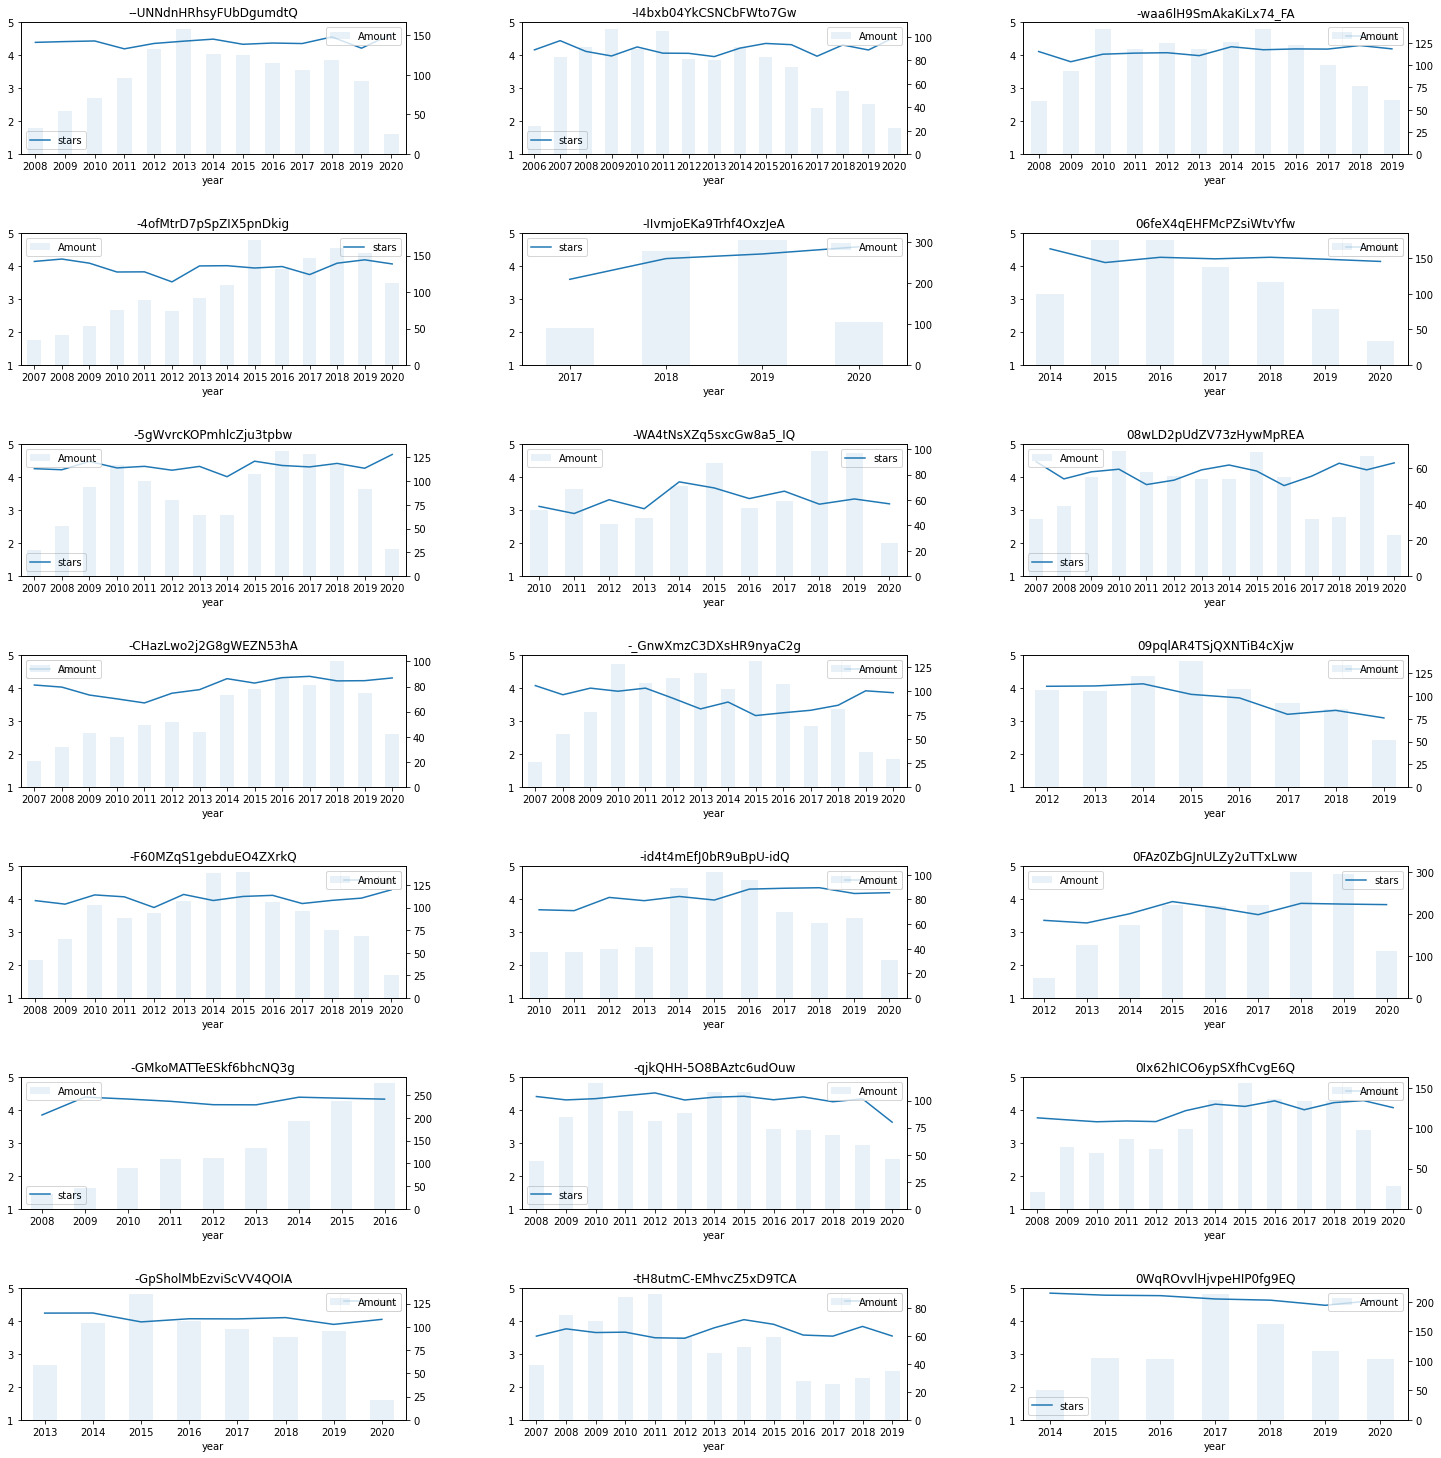

In [128]:
fig, ax = plt.subplots(7,3, figsize=(20,20))
fig.tight_layout()
fig.subplots_adjust(hspace=0.6, wspace=0.3)

y = 0
for i, (name, group) in enumerate(reviews.groupby(['business_id', 'year']).agg({"stars": "mean", "text": "count"}).reset_index().groupby('business_id')):
    # calc index
    x = i % 7
    if i != 0 and x == 0:
        y += 1
    group = group[group['text'] > 20]
    
    ax[x,y].set_ylim(1,5)
    group.plot(x='year', y='stars', ax=ax[x,y], title=name)
    
    twin = ax[x,y].twinx()
    
    group.plot(x='year', y='text', ax=twin, label='Amount', kind='bar', alpha=0.1)
    
    if i ==20:
        break

Most restaurants dont vary a whole lot and have a rather constant rating. Let's find out if there actually are restaurants where the rating varies with at least 1 star difference overall. 

In [130]:
reviews.groupby(['business_id', 'year']).agg({"stars": "mean", "text": "count"}).query('text > 20').reset_index().groupby('business_id').agg({"stars": lambda x: x.max() - x.min()}).sort_values("stars", ascending=False)


,stars
business_id,
zNqQSYafieEgxB2nZ8yAFQ,2.039706
4x3SvUgv6Di5Vs-hBN5HXw,1.978135
OFHWBXs5-UyEYf0-MrFDUw,1.837662
tt9gTrwhd_3v6AoQesEZmw,1.766530
smiGOZuyboXfc8LyC2jXpg,1.734345
...,...
PrWSjn4a8o4dHoqKs53GBA,0.113111
r1VBBIelTdjwtqE4pKwghA,0.090837
ERoYrBHNmTEEChY3RGaOGQ,0.082011


There are quite a few businesses whos rating changed substantially over time. Let us analyze the main drivers based on reviews (as the other data is not historized for us).

We will run LDA on the data for the different years, to hopefully spot the differences as mentioned in the topics. For this we will use the codeword LDA model proposed by Linhi.

We will apply it with a moving average window / or per year. I dont know yet. Hopefully we can then see the main topic assignments change over time

In [131]:
reviews.groupby(['business_id', 'year']).agg({"stars": "mean", "text": "count"}).reset_index().query("business_id == 'zNqQSYafieEgxB2nZ8yAFQ'")

,business_id,year,stars,text
12444,zNqQSYafieEgxB2nZ8yAFQ,2006,3.250000,4
12445,zNqQSYafieEgxB2nZ8yAFQ,2007,4.111111,18
12446,zNqQSYafieEgxB2nZ8yAFQ,2008,3.517241,29
12447,zNqQSYafieEgxB2nZ8yAFQ,2009,3.607143,56
12448,zNqQSYafieEgxB2nZ8yAFQ,2010,3.711340,97
12449,zNqQSYafieEgxB2nZ8yAFQ,2011,3.764706,136
12450,zNqQSYafieEgxB2nZ8yAFQ,2012,3.466102,118
12451,zNqQSYafieEgxB2nZ8yAFQ,2013,3.323308,133
12452,zNqQSYafieEgxB2nZ8yAFQ,2014,3.383648,159
12453,zNqQSYafieEgxB2nZ8yAFQ,2015,3.239234,209


We need to analyze all reviews at once with the LDA und VADER model, to get valid results

In [206]:
breview = reviews[reviews['business_id'] == 'zNqQSYafieEgxB2nZ8yAFQ']
breview.shape

breview = reviews

In [207]:
import re
# Remove punctuation
breview['text_processed'] = breview['text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
breview['text_processed'] = breview['text_processed'].map(lambda x: x.lower())

breview['text_processed'].head()

<>:4: DeprecationWarning: invalid escape sequence \.
<>:4: DeprecationWarning: invalid escape sequence \.
C:\Users\LUKASH~1\AppData\Local\Temp/ipykernel_17824/585241580.py:4: DeprecationWarning: invalid escape sequence \.
  breview['text'].map(lambda x: re.sub('[,\.!?]', '', x))


0    the food is always great here the service from...
1    i have been here twice and have had really goo...
2    great coffee and pastries baristas are excelle...
3    nothing special but good enough  i like anothe...
4    35 stars i got the avocado margarita and it wa...
Name: text_processed, dtype: object

put `GOOD_REVIEW` or `BAD_REVIEW` behind every positive or negative word respectively

In [208]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\Lukas
[nltk_data]     Hestermeyer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [211]:
from tqdm import tqdm

tqdm.pandas()  

In [213]:
import gensim
from gensim.utils import simple_preprocess
import nltk

stemmer = SnowballStemmer('english')
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text, deacc=True):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

data = breview.text_processed[0:50000].progress_map(preprocess).values.tolist()

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [03:21<00:00, 248.64it/s]


In [214]:
# make this more efficient with a dict to map each word to the preprocessed value.
mapdict = {}
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text, deacc=True):
        if mapdict.get(token):
            return mapdict.get(token)
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            prepped_word = lemmatize_stemming(token)
            result.append(prepped_word)
            mapdict['token'] = prepped_word
    return result


In [ ]:
breview.shape

In [215]:
data_words = list(sent_to_words(data))# remove stop words

print(data_words[:1][0][:30])

['food', 'great', 'servic', 'manag', 'staff', 'super', 'draw', 'restaur', 'super', 'loud', 'snag', 'patio', 'tabl']


In [216]:
text_file = open("../data/positives.txt", "r")
positives = [s.replace('\n', '') for s in text_file.readlines()]


text_file = open("../data/negatives.txt", "r")
negatives = [s.replace('\n', '') for s in text_file.readlines()]


In [217]:
# stem negatives and positives
positives = list(set([preprocess(p)[0] for p in positives if preprocess(p) != []]))
positives.sort()

negatives = list(set([preprocess(n)[0] for n in negatives if preprocess(n) != []]))
negatives.sort()

In [188]:
new_data_words = []
for sentence in data_words:
    new_sentence = []
    for word in sentence:
        new_sentence.append(word)
        if word in positives and np.random.random() > 0.9:
            new_sentence.append('GOOD_REVIEW')
        elif word in negatives and np.random.random() > 0.9:
            new_sentence.append('BAD_REVIEW')
    new_data_words.append(new_sentence)


In [219]:
print(new_data_words[:10])

[['food', 'great', 'servic', 'manag', 'staff', 'super', 'draw', 'restaur', 'super', 'loud', 'snag', 'patio', 'tabl'], ['twice', 'good', 'food', 'servic', 'time', 'burger', 'caramel', 'onion', 'wine', 'sauc', 'believ', 'blue', 'chees', 'time', 'excel', 'right', 'size', 'hate', 'go', 'order', 'burger', 'bigger', 'head', 'finish', 'half', 'flip', 'burger', 'size', 'home', 'second', 'time', 'go', 'limit', 'time', 'season', 'offer', 'venison', 'burger', 'shoot', 'kind', 'chees', 'remind', 'brie', 'sweet', 'syrupi', 'sauc', 'overal', 'good', 'onion', 'ring', 'possibl', 'best', 'onion', 'ring', 'thing', 'like', 'flip', 'atmospher', 'layout', 'tabl', 'guess', 'go', 'trendi', 'upscal', 'make', 'feel', 'school', 'cafeteria', 'high', 'school', 'like', 'long', 'white', 'tabl', 'shove', 'uncomfort', 'modern', 'look', 'plastic', 'chair', 'kind', 'look', 'like', 'come', 'ikea', 'pretti', 'loud', 'absorb', 'sound', 'like', 'school', 'cafeteria', 'time', 'coupl', 'women', 'small', 'children', 'idea', '

In [218]:
new_data_words = data_words

Now train LDA

In [220]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(new_data_words)

# Create Corpus
texts = new_data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1)]


In [221]:
from pprint import pprint

# number of topics
num_topics = 8

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.015*"food" + 0.013*"good" + 0.012*"order" + 0.012*"come" + 0.011*"place" '
  '+ 0.010*"great" + 0.010*"time" + 0.009*"like" + 0.008*"restaur" + '
  '0.008*"love"'),
 (1,
  '0.017*"like" + 0.013*"good" + 0.009*"donut" + 0.009*"place" + 0.007*"food" '
  '+ 0.007*"time" + 0.007*"order" + 0.006*"go" + 0.005*"come" + '
  '0.005*"servic"'),
 (2,
  '0.029*"good" + 0.024*"food" + 0.018*"great" + 0.017*"place" + '
  '0.012*"servic" + 0.009*"restaur" + 0.008*"best" + 0.008*"come" + '
  '0.008*"pretti" + 0.008*"time"'),
 (3,
  '0.027*"place" + 0.021*"food" + 0.014*"great" + 0.014*"love" + 0.011*"good" '
  '+ 0.009*"wait" + 0.009*"friend" + 0.008*"come" + 0.008*"fri" + '
  '0.008*"like"'),
 (4,
  '0.018*"like" + 0.017*"good" + 0.014*"place" + 0.013*"great" + '
  '0.010*"burger" + 0.010*"food" + 0.009*"delici" + 0.008*"order" + '
  '0.008*"time" + 0.008*"donut"'),
 (5,
  '0.019*"food" + 0.013*"time" + 0.012*"place" + 0.012*"chicken" + '
  '0.012*"servic" + 0.010*"order" + 0.010*"good" + 0

In [223]:
import pyLDAvis.gensim_models
import pickle 
import os
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('../results/ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
    
pyLDAvis.save_html(LDAvis_prepared, '../results/ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared

C:\anaconda3\envs\yelp\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.003188 -0.001043       1        1  21.363887
5     -0.019873  0.017386       2        1  14.117849
7     -0.009158  0.007429       3        1  13.243689
6     -0.000645 -0.019334       4        1  12.725298
2     -0.016594 -0.001645       5        1  11.668086
3     -0.013045 -0.003778       6        1  10.268402
4      0.024796 -0.021995       7        1   9.682069
1      0.037708  0.022981       8        1   6.930721, topic_info=        Term          Freq         Total Category  logprob  loglift
21    burger  11770.000000  11770.000000  Default  30.0000  30.0000
187    donut   6684.000000   6684.000000  Default  29.0000  29.0000
38      good  32909.000000  32909.000000  Default  28.0000  28.0000
52      like  19449.000000  19449.000000  Default  27.0000  27.0000
63     place  29978.000000  29978.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
2      great    697.434459  25014.574814   Topic8  -5.3485  -0.9106
6    restaur    518.925714  12927.807888   Topic8  -5.6442  -0.5462
57      menu    496.011089   9202.738101   Topic8  -5.6893  -0.2515
55      look    474.014295   6781.503711   Topic8  -5.7347   0.0085
110   delici    485.652308  12036.726668   Topic8  -5.7104  -0.5410

[742 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
16945      8  0.902709          abbi
628        1  0.168074       absolut
628        2  0.126340       absolut
628        3  0.146069       absolut
628        4  0.106232       absolut
...      ...       ...           ...
6281       5  0.714433        zydeco
22088      6  0.671830    ゆっくり食へていると
22089      6  0.671501       ハンクーハーて
22091      6  0.671474  手打ち麺はのひやすいのて
22092      6  0.671260     結論から述へますと

[2231 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 8, 7, 3, 4, 5, 2])

Two things I realize.

1. My dataset is too biased on restaurants with good ratings (we have only the top restaurants, and they usually have high ratings, if they have so many, it means many ppl go there and therefore it must not be shabby)
2. LDA could possibly perform better, if I only train it on nouns and use VADER for sentiment regarding those nouns. Maybe then I am able to split 

In [222]:
#importing wordtovec embeddings 
from gensim.models import KeyedVectors
pretrained_embeddings_path = "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
word2vec = KeyedVectors.load_word2vec_format(pretrained_embeddings_path, binary=True)

KeyboardInterrupt: 

In [27]:
import matplotlib.pyplot as plt

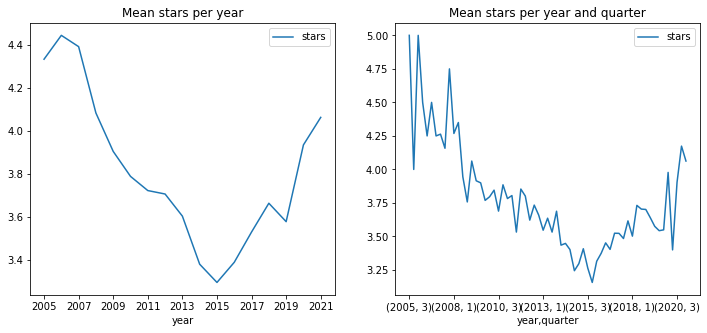

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

reviews['year'] = reviews['date'].str[0:4]
reviews['quarter'] = pd.to_datetime(reviews['date'], format='%Y-%m-%d').dt.quarter

reviews.groupby('year').agg({"stars": "mean", "business_id": "count"}).plot(y='stars', use_index=True, ax = ax[0])
ax[0].set_title('Mean stars per year') 
reviews.groupby(['year', 'quarter']).agg({"stars": "mean", "business_id": "count"}).plot(y='stars', use_index=True, ax = ax[1])
ax[1].set_title('Mean stars per year and quarter')
plt.show()

As this is already the most reviewed restaurant, I would say smoothing to year would be a valid approach, although ratings do not vary a whole lot in this example for year quarter as well. 

Let's analyze this example, as to what topics were most discussed by the users in a given year or quarter.

For topic extraction, we will be using LDA, but we will extend it as Shin Linshi proposed in his work [[1]](TOBEADDED)

In [35]:
reviews['text']

0       I am alway leery of places the trade on schtic...
1       It's a must when visitors come to town, not th...
2       The maple bacon bar is to die for. I live in P...
3       Innovative types of donuts but a bit priceyy (...
4       Love!  Bacon-Maple Bars are my favorite, but s...
                              ...                        
9290    Order ahead for curbside pickup.  They have yu...
9291    Best doughnuts I've had in a long time...maybe...
9292    The VooDoo experience is a must do in Portland...
9293    Not sure if the wait is worth the donuts. They...
9294    These guys did a really good job managing the ...
Name: text, Length: 9295, dtype: object

In [51]:
photos.label.unique()

array(['drink', 'food', 'interior', 'outside', 'menu'], dtype=object)

In [52]:
photos.shape

(200000, 4)